# Importing the Libraries and Loading the Data

In [244]:
import pandas as pd
import numpy as np

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline

In [245]:
df = pd.read_csv("corona_fake_news.csv")

In [246]:
df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


# Data Preprocessing

In [247]:
df["label"].value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

## Replacing Labels
Since there are 2 FAKE labels combining them to single value

In [248]:
df["label"] = df["label"].str.replace("fake", "Fake", case = False)
df["label"] = df["label"].str.replace("Fake", "FAKE", case = False)

In [249]:
df["label"].value_counts()

TRUE    584
FAKE    575
Name: label, dtype: int64

## Filling rows with missing labels

In [250]:
label_column = df[df["label"].isnull()].index.to_list()
print(label_column)
#classify manually whether the news is fake or not by reading the title
for i in label_column:
    print(df.loc[i]["title"])
########################################
df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

[5, 15, 43, 131, 242]
CORONA UNMASKED: Chinese Intelligence Officer Reveals True Magnitude of China’s Fake “Coronavirus” Crisis
You can recover from the coronavirus disease (COVID-19). Catching the new coronavirus DOES NOT mean you will have it for life.
Pandemic Bio-Weapon – 9. Supervirus Created by US during Obama’s Govt: 89 CoVid Strains in CIA’s Top Secret Tests
Why the Coronavirus Seems to Hit Men Harder Than Women
The Coronavirus 5G Connection and Coverup


## Filling missing Values

In [251]:
print(df.isnull().sum())

df=df.fillna(' ')
print(df.isnull().sum())

title     82
text      10
source    20
label      0
dtype: int64
title     0
text      0
source    0
label     0
dtype: int64


In [252]:
# We have title and text columns related to eachother so if we combined them it will be helpful and solve the problem of null values
df["combined"] = df["text"] + " " + df["title"]

## Punctuation Removal and converting data to lowercase

In [253]:
df["combined"] = df["combined"].str.replace('[^\w\s]', '', regex=True)#(\w letter in word character, \s whitespace both negated using ^)
df["combined"] = df["combined"].str.lower()

In [254]:
df["combined"][0]

'you just need to add water and the drugs and vaccines are ready to be administered there are two parts to the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound to create mix two parts together in a chosen combination add water and the treatment is ready due to the recent outbreak for the coronavirus covid19 the world health organization is giving away vaccine kits just pay 495 for shipping'

In [255]:
df["combined"][45]

'the covid2019 epidemic which began in the chinese city of wuhan managed to get out of china and spread throughout the world in two months in midmarch an article became popular in social networks according to which a dangerous strain was artificially created as part of a study of bat coronavirus by american scientists the scientific work was written by a team of biologists back in 2015 on november 9 of the same year it was published on the scientific portal nature  researchers studied the shco14 virus found in chinese horseshoe bats scientists combined this strain with another  its name is sars and it causes a severe acute respiratory syndrome or sars further the researchers generated and characterized a chimeric virus that can  multiply in the primary cells of the human respiratory tract in other words biologists altered the coronavirus of bats so much that they got a strain that could infect a person  and the virus would cause severe pneumonia in him among the authors of the article 

## Word Cloud Visualization

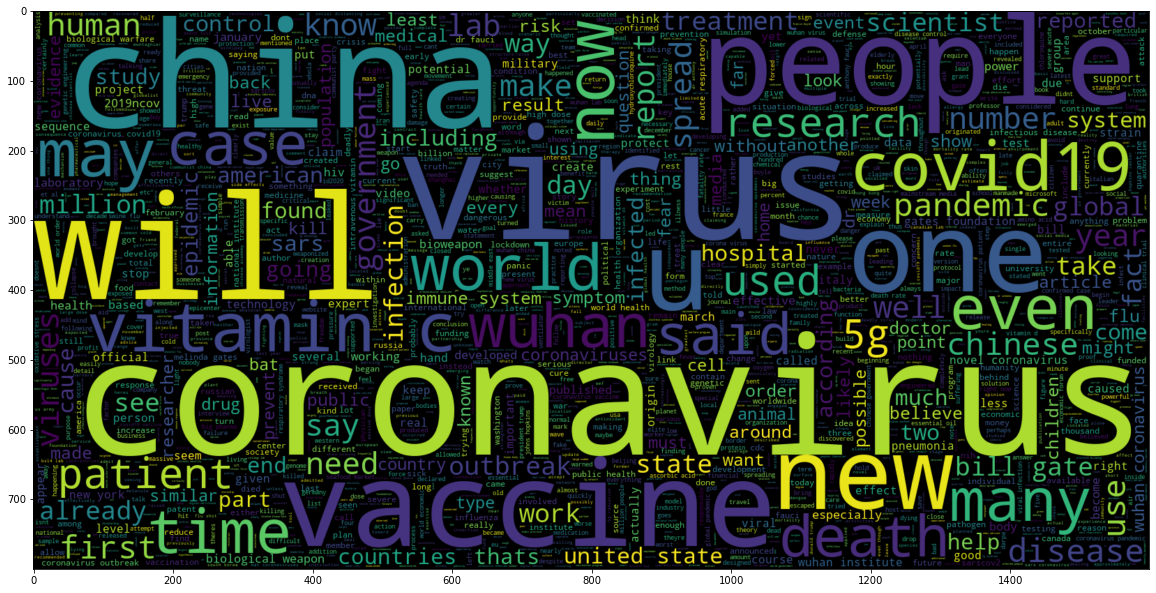

In [161]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.label == "FAKE"].combined))
plt.imshow(wc, interpolation = "bilinear")

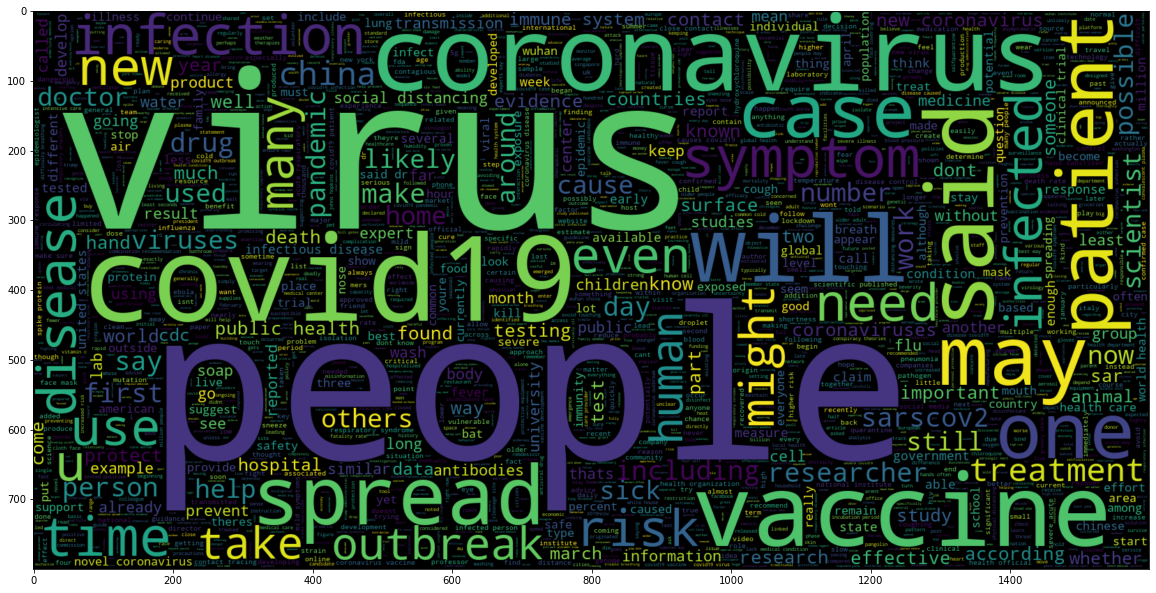

In [162]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.label == "TRUE"].combined))
plt.imshow(wc, interpolation = "bilinear")

## Splitting the dataset into Training and Testing

In [256]:
y = df.label
y

0       FAKE
1       FAKE
2       FAKE
3       FAKE
4       FAKE
        ... 
1159    TRUE
1160    TRUE
1161    TRUE
1162    TRUE
1163    TRUE
Name: label, Length: 1164, dtype: object

In [257]:
df.drop("label", axis = 1, inplace = True)

In [258]:
X = df["combined"]

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)


## Cleaning the Data using tfidf

In [260]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Implementing Classification Algorithm

## Support vector machine

In [261]:
classifier = svm.SVC(kernel = "linear")

## Applying Grid Search to find the best model and parameters

In [262]:
from sklearn.model_selection import GridSearchCV
parameters = [{"C" : [0.25, 0.5, 0.75, 1], "kernel" : ["linear"]},
              {"C" : [0.25, 0.5, 0.75, 1], "kernel" : ["rbf"], "gamma" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          scoring = "accuracy", 
                          cv = 10,
                          n_jobs = -1)
grid_search.fit(tfidf_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 93.66 %
Best Parameters: {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [263]:
model = svm.SVC(kernel = "rbf", C = 1, gamma = 0.6)
model.fit(tfidf_train, y_train)

SVC(C=1, gamma=0.6)

## Printing Confusion matrix and Accuracy of the model

In [264]:
y_pred = model.predict(tfidf_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[119   7]
 [  7 100]]


0.9399141630901288

# Pipeline Creation

In [265]:
pipeline = Pipeline([("tfidf", TfidfVectorizer(stop_words="english", max_df=0.80)),
                    ("clf", svm.SVC(kernel = "rbf", C = 1, gamma = 0.6))])

In [266]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('clf', SVC(C=1, gamma=0.6))])

In [267]:
result=pipeline.predict(["One of the challenges being faced worldwide is the rate of infection of health professionals while treating COVID-19 patients.  2016 statistics show the following picture of Rwanda’s health sector: 1/50,505 ground ambulance / population Ratio; 1/10,055 Doctor/population ratio; 1/1,094 Nurse/population ratio; 1/10,500 Laboratory technicians /population ratio. Although Rwanda is on track to meeting most of the required quota, the country cannot afford the set back that a pandemic like COVID-19 among health professionals would cause. To minimize contact time with confirmed cases and therefore reducing the risk of contamination of health professionals in COVID-19 treatment centres, robots were deployed. At Gatenga and Kanyinya treatment centres in Kigali City, visits by medical staff to patients went from 3-4 to 2 per day since May 2020. The 5 human-size robots are programmed to perform temperature screening, take readings of vitals, deliver video messages and detect people not wearing masks then instruct them to wear masks properly. On Tuesday, May 19 at the Kanyinya COVID-19 Treatment Centre, the 5 robots were launched by the Ministry of Health. Named in Kinyarwanda, Akazuba, Ikirezi, Mwiza, Ngabo, and Urumuri are made by Zora Bots, a Belgian company specialised in robotics. They were acquired through a partnership between the UNDP Rwanda Accelerator Lab (AccLab) and the Ministry of ICT and Innovation.  Each robot costs about $30,000. Urumuri is currently deployed at the Kigali International Airport with the capacity to screen 50 to 150 people per minute and report abnormalities to officers on duty. As Rwanda is reopening Kigali International Airport for commercial international flights from 1st of August, Urumuri will allow to speed up mass screenings of fever for passengers as they land. Smart anti-epidemic robots have been used in Asia to help flatten the COVID-19 curve. The pandemic has proven to be a crosscutting challenge affecting Rwanda in all sectors (Health, Economy, Education, Agriculture, …). It therefore requires different sometimes innovative solutions with available resources like robots."])
print(result)

['TRUE']
